# Figure 5 – Functional validation of pathogenic TP53 variants identified with prime editing screening.
## Figure 5a
LFC of 29 pegRNAs selected for validation at Day 34 in the Nutlin-treated condition. Variants with insufficient control counts (I195T, E285K, G325A, Y327Ter, A347D) represented with LFC = 0.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
#import re
import scipy.stats
import regex as re
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='Helvetica')

In [2]:
#fishing out the pegRNAs used in the competition assay

p53_filtered = pd.read_csv('p53_PE_sensor_FINAL_clean.csv')


p_ids = ['peg_16602', 'peg_465', 'peg_2','peg_218', 'peg_31', 'peg_311', 'peg_178', 'peg_885', 'peg_683', 'peg_14531', 'peg_8247', 'peg_12022', 'peg_7449', 'peg_21875', 'peg_12868', 'peg_18555', 'peg_25828', 'peg_22204', 'peg_138', 'peg_6764', 'peg_4583', 'peg_1864', 'peg_9611', 'peg_27888', 'peg_26951','peg_26576', 'peg_21343', 'peg_4127', 'peg_55']

comp = p53_filtered[p53_filtered['peg_id'].isin(p_ids)].reset_index().drop(columns='index')

In [3]:
#loading in the merged replicates and merging with the competition assay
fp = "crispresso_replicates_merged"
reorder = []
conditions = ['D4', 'D16', 'D16-NUT', 'D25', 'D25-NUT', 'D34', 'D34-NUT']
for i in conditions:
    df = pd.read_csv(f"{fp}/{i}_reps_combined.csv")
    df['peg_id'] = p53_filtered['peg_id']
    reorder.append(df)

cp_dict2 = dict(zip(conditions, reorder))
samps = list(cp_dict2.keys())[1:]


#reading in mageck to extract LFC
fp = './MAGeCK analysis'
files = os.listdir(fp)
files = sorted([f for f in files if f[-3:]=='txt'])

dfs = []
for i,f in enumerate(files):
    df = pd.read_csv(fp + '/' + f, sep='\t')

    #ensure naming is correct
    assert f[:3]==samps[i][:3]

    #reorder the pegs...
    df = df.rename(columns = {'sgrna':'peg_id'})
    df_merge = pd.merge(p53_filtered, df, how='left', on='peg_id')

    #also add in merge of cp_dict?

    dfs.append(df_merge)


#perform thresholding of control_mean counts (filtering out pegRNAs with below 10 control counts mean)
#differences in counts because of normalization
#going to do it for one and apply it to all...

control_mean_threshold = 10

#d16
dd = dfs[0]
dd = dd[dd['control_mean']>=control_mean_threshold]
pegs_above_thres = dd['peg_id']

dfs2 = []
for i in dfs:
    dfs2.append(i[i['peg_id'].isin(pegs_above_thres)])


assert list(dfs2[0]['peg_id']) == list(dfs2[1]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[2]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[3]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[4]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[5]['peg_id']) 

mageck_dict = dict(zip(samps, dfs2))

In [4]:
#extracting information and merging with competition assay dataframe
d34_cp = []
d34_nut_cp = []
d34_lfc = []
d34_nut_lfc = []

counts_threshold = 10

cp_untreated = []
cp_nutlin = []

for i in comp['peg_id']:
    #editing efficiency quantification
    d34 = cp_dict2['D34']
    d34 = d34[d34['Reads_aligned_all_amplicons'] >= counts_threshold]

    d34_nut = cp_dict2['D34-NUT']
    d34_nut = d34_nut[d34_nut['Reads_aligned_all_amplicons'] >= counts_threshold]

    d34 = d34[d34['peg_id']==i]
    d34_nut = d34_nut[d34_nut['peg_id']==i]

    if len(d34)>0: #if sufficient sensor counts
        d34_cp.append(d34['corr_perc_backsub'].values[0])
        cp_untreated.append(False)
    else:
        cp_untreated.append(True)
        d34_cp.append(0)

    if len(d34_nut)>0: #if sufficient sensor counts
        d34_nut_cp.append(d34_nut['corr_perc_backsub'].values[0])
        cp_nutlin.append(False)
    else:
        cp_nutlin.append(True)
        d34_nut_cp.append(0)

    #LFC quantification
    d34_m = mageck_dict['D34']
    d34_nut_m = mageck_dict['D34-NUT']

    d34_m = d34_m[d34_m['peg_id']==i]
    d34_nut_m = d34_nut_m[d34_nut_m['peg_id']==i]

    if len(d34_m)>0: #if sufficient sensor counts
        d34_lfc.append(d34_m['LFC'].values[0])
    else:
        d34_lfc.append(0)

    if len(d34_nut_m)>0: #if sufficient sensor counts
        d34_nut_lfc.append(d34_nut_m['LFC'].values[0])
    else:
        d34_nut_lfc.append(0)


comp['Corr_perc_untreated'] = d34_cp
comp['Corr_perc_nutlin'] = d34_nut_cp
comp['LFC_untreated'] = d34_lfc
comp['LFC_nutlin'] = d34_nut_lfc

#add info about where thresholds have been applied
comp['insufficient_LFC_counts'] = list(comp['LFC_nutlin']==0)
comp['insufficient_sensor_counts_untreated'] = cp_untreated
comp['insufficient_sensor_counts_nutlin'] = cp_nutlin

#and adding in some other info
mut = []
for idx, val in comp.iterrows():
    aa = val['HGVSp']
    type1 = val['variant_type']
    conseq = val['consequence']
    if conseq in ['Silent']:
        mut.append(conseq)
    else:
        mut.append(type1)


comp['Effect'] = mut
c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'grey'}
comp['colors'] = [c_dict[i] for i in comp['Effect']]

5

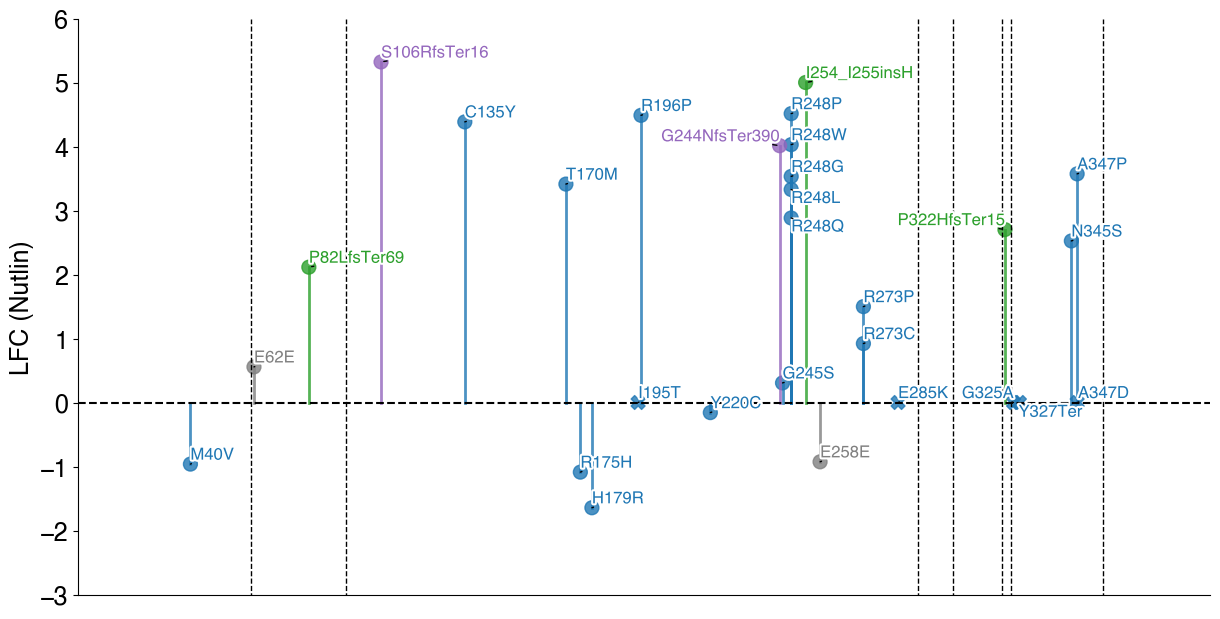

In [5]:
#and then plot

fig, ax = plt.subplots( figsize=(12,6))

c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'grey'}
comp['colors'] = [c_dict[i] for i in comp['Effect']]
colors = list(comp['colors'])

lfc = comp['LFC_nutlin']

for i, v in comp.iterrows():
    val = v['codon']
    ax.plot([val, val], [0, lfc[i]], color = colors[i], linewidth=2, alpha=.8)

above_thres = comp[comp['insufficient_LFC_counts']==False]
below_thres = comp[comp['insufficient_LFC_counts']==True]


ax.scatter(above_thres['codon'], above_thres['LFC_nutlin'], color=above_thres['colors'], s=100, alpha=.8)
ax.scatter(below_thres['codon'], below_thres['LFC_nutlin'], color=below_thres['colors'], s=100, alpha=.8, marker='X')

ax.set_xlim(1,393)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xticks([])
ax.set_ylabel("LFC (Nutlin)", fontsize=18)


boundaries = [61,94,292,304,321,324,356]
for bound in boundaries:
    ax.plot([bound, bound],[-6,6], linewidth=1, linestyle='dashed', color='black')


ax.plot([1,393], [0,0], linestyle='dashed', color='black')

t = list(comp['HGVSp'])
x=np.array(comp['codon'])
y = comp['LFC_nutlin']#+np.random.uniform(0,.5, len(x))
colors = list(comp['colors'])

texts = [ax.text(x[i], y[i], t[i], fontsize=12, color=colors[i], path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

ax.set_ylim(-3,6)

#adjust_text(texts, ax=ax[0])
fig.tight_layout(pad=0)

adjust_text(texts,only_move={'points':'y', 'texts':'y'},arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'), ax=ax)

## Figure 5c

See extended_figures.ipynb for full competition assay results, including representative examples shown in 5c.

## Figure 5d

The change in the RFP positive cell fraction (∆RFP %) from the Day 0 to the Day 7 and Day 14 time-points for each variant in the presence or absence of Nutlin-3. 

In [6]:
p53_filtered = pd.read_csv('p53_PE_sensor_FINAL_clean.csv')

p_ids = ['peg_16602', 'peg_465', 'peg_2','peg_218', 'peg_31', 'peg_311', 'peg_178', 'peg_885', 'peg_683', 'peg_14531', 'peg_8247', 'peg_12022', 'peg_7449', 'peg_21875', 'peg_12868', 'peg_18555', 'peg_25828', 'peg_22204', 'peg_138', 'peg_6764', 'peg_4583', 'peg_1864', 'peg_9611', 'peg_27888', 'peg_26951','peg_26576', 'peg_21343', 'peg_4127', 'peg_55']
comp = p53_filtered[p53_filtered['peg_id'].isin(p_ids)].reset_index().drop(columns='index')


In [7]:
#loading in the merged replicates and merging with the competition assay
fp = "crispresso_replicates_merged"
reorder = []
conditions = ['D4', 'D16', 'D16-NUT', 'D25', 'D25-NUT', 'D34', 'D34-NUT']
for i in conditions:
    df = pd.read_csv(f"{fp}/{i}_reps_combined.csv")
    df['peg_id'] = p53_filtered['peg_id']
    reorder.append(df)

cp_dict2 = dict(zip(conditions, reorder))
samps = list(cp_dict2.keys())[1:]

#reading in mageck to extract LFC
fp = './MAGeCK analysis'
files = os.listdir(fp)
files = sorted([f for f in files if f[-3:]=='txt'])

dfs = []
for i,f in enumerate(files):
    df = pd.read_csv(fp + '/' + f, sep='\t')

    #ensure naming is correct
    assert f[:3]==samps[i][:3]

    #reorder the pegs...
    df = df.rename(columns = {'sgrna':'peg_id'})
    df_merge = pd.merge(p53_filtered, df, how='left', on='peg_id')

    #also add in merge of cp_dict?
    dfs.append(df_merge)


#perform thresholding of control_mean counts (filtering out pegRNAs with below 10 control counts mean)
#differences in counts because of normalization
#going to do it for one and apply it to all...

control_mean_threshold = 10

#d16
dd = dfs[0]
dd = dd[dd['control_mean']>=control_mean_threshold]
pegs_above_thres = dd['peg_id']

dfs2 = []
for i in dfs:
    dfs2.append(i[i['peg_id'].isin(pegs_above_thres)])

assert list(dfs2[0]['peg_id']) == list(dfs2[1]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[2]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[3]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[4]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[5]['peg_id']) 

mageck_dict = dict(zip(samps, dfs2))

In [8]:
#extracting information and merging with competition assay dataframe
d34_cp = []
d34_nut_cp = []
d34_lfc = []
d34_nut_lfc = []

counts_threshold = 10

cp_untreated = []
cp_nutlin = []

for i in comp['peg_id']:
    #editing efficiency quantification
    d34 = cp_dict2['D34']
    d34 = d34[d34['Reads_aligned_all_amplicons'] >= counts_threshold]

    d34_nut = cp_dict2['D34-NUT']
    d34_nut = d34_nut[d34_nut['Reads_aligned_all_amplicons'] >= counts_threshold]

    d34 = d34[d34['peg_id']==i]
    d34_nut = d34_nut[d34_nut['peg_id']==i]

    if len(d34)>0: #if sufficient sensor counts
        d34_cp.append(d34['corr_perc_backsub'].values[0])
        cp_untreated.append(False)
    else:
        cp_untreated.append(True)
        d34_cp.append(0)

    if len(d34_nut)>0: #if sufficient sensor counts
        d34_nut_cp.append(d34_nut['corr_perc_backsub'].values[0])
        cp_nutlin.append(False)
    else:
        cp_nutlin.append(True)
        d34_nut_cp.append(0)

    #LFC quantification
    d34_m = mageck_dict['D34']
    d34_nut_m = mageck_dict['D34-NUT']

    d34_m = d34_m[d34_m['peg_id']==i]
    d34_nut_m = d34_nut_m[d34_nut_m['peg_id']==i]

    if len(d34_m)>0: #if sufficient sensor counts
        d34_lfc.append(d34_m['LFC'].values[0])
    else:
        d34_lfc.append(0)

    if len(d34_nut_m)>0: #if sufficient sensor counts
        d34_nut_lfc.append(d34_nut_m['LFC'].values[0])
    else:
        d34_nut_lfc.append(0)


comp['Corr_perc_untreated'] = d34_cp
comp['Corr_perc_nutlin'] = d34_nut_cp
comp['LFC_untreated'] = d34_lfc
comp['LFC_nutlin'] = d34_nut_lfc

#add info about where thresholds have been applied
comp['insufficient_LFC_counts'] = list(comp['LFC_nutlin']==0)
comp['insufficient_sensor_counts_untreated'] = cp_untreated
comp['insufficient_sensor_counts_nutlin'] = cp_nutlin

#and adding in some other info
mut = []
for idx, val in comp.iterrows():
    aa = val['HGVSp']
    type1 = val['variant_type']
    conseq = val['consequence']
    if conseq in ['Silent']:
        mut.append(conseq)
    else:
        mut.append(type1)


comp['Effect'] = mut

In [9]:
high1 = comp[comp['Corr_perc_nutlin']>=30].index
low1 = comp[comp['Corr_perc_nutlin']<=9.4].index
med1 = comp[(comp['Corr_perc_nutlin']>9.4) & (comp['Corr_perc_nutlin']<30)].index

comp['efficiency'] = np.zeros(len(comp))
comp.loc[high1, 'efficiency'] = 'high'
comp.loc[med1, 'efficiency'] = 'medium'
comp.loc[low1, 'efficiency'] = 'low'

In [10]:
fp1 = 'competition_asay_data_FULL'

#read the plate set up into a dictionary
l1 = os.listdir(fp1)
l1 = sorted([i for i in l1 if i[-3:]=='csv'])

df_holder = []
for i in l1:
    a = pd.read_csv(f'{fp1}/{i}')
    df_holder.append(a)

key_dict = dict(zip(l1, df_holder))

In [11]:
#then read in the compeition assay flow data
#processed with FlowJo

fp2 = 'competition_asay_data_FULL/processed_data'
l2 = os.listdir(fp2)
l2 = sorted([i for i in l2 if i[-3:]=='csv'])

#and match up plate set up with correct files
#make a joint table for matching things up

matching = [None,
'A549-PEmax-p53ODmuts-WellplateSetup-plate1.csv',
'A549-PEmax-p53ODmuts-WellplateSetup-plate2.csv',
'A549-PEmax-p53ODmuts-WellplateSetup-plate1.csv',
 'A549-PEmax-p53ODmuts-WellplateSetup-plate2.csv',
 'A549-PEmax-p53ODmuts-WellplateSetup-plate1.csv',
 'A549-PEmax-p53ODmuts-WellplateSetup-plate2.csv',
 None,
 'A549-PEmax-pegRNAvalidation-REDO-WellplateSetup-plate1.csv',
 'A549-PEmax-pegRNAvalidation-REDO-WellplateSetup-plate2.csv',
 'A549-PEmax-pegRNAvalidation-REDO-WellplateSetup-plate1.csv',
 'A549-PEmax-pegRNAvalidation-REDO-WellplateSetup-plate2.csv',
]

match_df = pd.DataFrame(dict(zip(['file', 'template'], [l2, matching])))
match_df

,file,template
0,A549-ODmuts-T0.csv,None
1,A549-PEmax-ODmuts-T1-plate1.csv,A549-PEmax-p53ODmuts-WellplateSetup-plate1.csv
2,A549-PEmax-ODmuts-T1-plate2.csv,A549-PEmax-p53ODmuts-WellplateSetup-plate2.csv
3,A549-PEmax-ODmuts-T2-plate1.csv,A549-PEmax-p53ODmuts-WellplateSetup-plate1.csv
4,A549-PEmax-ODmuts-T2-plate2.csv,A549-PEmax-p53ODmuts-WellplateSetup-plate2.csv
5,A549-PEmax-ODmuts-T3-plate1.csv,A549-PEmax-p53ODmuts-WellplateSetup-plate1.csv
6,A549-PEmax-ODmuts-T3-plate2.csv,A549-PEmax-p53ODmuts-WellplateSetup-plate2.csv
7,A549-PEmax-T0.csv,None
8,A549-PEmax-T1-plate1.csv,A549-PEmax-pegRNAvalidation-REDO-WellplateSetu...
9,A549-PEmax-T1-plate2.csv,A549-PEmax-pegRNAvalidation-REDO-WellplateSetu...


In [12]:
def read_samples(t0_df, match_df):
    """ 
    Function for reading in competition assay samples
    """

    col_dict = {'singlets/singlets2/singlets3 | Count': 'cell_count', 'singlets/singlets2/singlets3/RFP+ | Freq. of Parent (%)': 'RFP+ %'}
    dh = []

    for i, val in match_df.iterrows():
        f = val['file']
        t = val['template']
        #if t!=None:

        time = int(f.split('-')[-2][-1])
        

        aa = pd.read_csv(f'{fp2}/{f}')
        ident = []
        for i in aa['Unnamed: 0']:
            if '.fcs' in i:
                id = i.split('_')[-2]
                ident.append(id)

        aa = aa[:-2] #get rid of mean and SD files
        aa['Well'] = ident
        
        t_df = key_dict[t]

        m1 = pd.merge(aa, t_df, on='Well', how='left')
        
        m1['Timepoint'] = time

        m1 = m1.rename(columns = col_dict)
        dh.append(m1)

    #concatenate timepoints  
    concat_df = pd.concat(dh)

    #and finally add in T0 timepoint data...
    aa = pd.read_csv(f'{fp2}/{l2[7]}')
    aa = t0_df
    aa = aa.rename(columns = {'Unnamed: 0':'pegRNA Identity'})
    aa = aa.rename(columns = col_dict)

    aa = aa[:-2]
    aa['pegRNA Identity'] = [i[:-4] for i in aa['pegRNA Identity']]
    aa['Timepoint'] = 0
    aa.loc[[0,1,2], 'pegRNA Identity'] = 'CONTROL'
    aa['Treatment'] = 'Untreated'
    aa2 = aa.copy()
    aa2['Treatment'] = 'Treated'


    #final concat
    concat_a549 = pd.concat([concat_df, aa, aa, aa, aa2, aa2, aa2])

    #and fix sample names
    #concat_a549['pegRNA Identity'] = [i.upper() for i in concat_a549['pegRNA Identity']]


    concat_a549['Treatment'] = concat_a549['Treatment'].fillna('Untreated')
    concat_a549 = concat_a549.reset_index()

    return concat_a549

def event_correction(concat_a549_OD, timepoint_final=2, event_threshold=500):
    """ 
    Function for correction of RFP% when below a certain event threshold;
    If sample is below threshold, this function transforms the dataframe so that 
    the RFP% is equal to that at the previous timepoint
    """
    #event_threshold = 500

    if timepoint_final==2:
        t0 = concat_a549_OD[concat_a549_OD['Timepoint']==0]
        t1 = concat_a549_OD[concat_a549_OD['Timepoint']==1]
        t2 = concat_a549_OD[concat_a549_OD['Timepoint']==2]
        lh = [t1, t2]
        #t3 = concat_a549_OD[concat_a549_OD['Timepoint']==3]
    elif timepoint_final==3:
        t0 = concat_a549_OD[concat_a549_OD['Timepoint']==0]
        t1 = concat_a549_OD[concat_a549_OD['Timepoint']==1]
        t2 = concat_a549_OD[concat_a549_OD['Timepoint']==2]
        t3 = concat_a549_OD[concat_a549_OD['Timepoint']==3]
        lh = [t1,t2,t3]
    else:
        assert 1==0, print('CORRECT THE FUNCTION TO ACCOUNT FOR DIFFERENT NUMBER OF TIME-POINTS')

    corrected_df = concat_a549_OD.copy()
    corrected_df['Corrected']=False

    #new_dfs = [t0]
    for t, val1 in enumerate(lh):
        x = val1
        x_copy = x.copy()
        timepoint_prev = t
        for i, val in x.iterrows():

            if val['cell_count']< event_threshold:

                v = val['pegRNA Identity']
                r = val['Replicate']
                tr = val['Treatment']

                t_previous = corrected_df[corrected_df['Timepoint']==timepoint_prev]

                if timepoint_prev >0:
                    kk =t_previous[(t_previous['pegRNA Identity']==v)&(t_previous['Replicate']==r)&(t_previous['Treatment']==tr)]['RFP+ %'].values[0]
                elif timepoint_prev==0:
                    kk =t_previous[(t_previous['pegRNA Identity']==v)]['RFP+ %'].values[0]
                
                assert str(x_copy.loc[i, 'pegRNA Identity'])==v, print(x_copy.loc[i, 'pegRNA Identity'])
                corrected_df.loc[i, 'RFP+ %'] = kk
                corrected_df.loc[i, 'Corrected'] = True
                
            else:
                continue

    return corrected_df

In [13]:
t0_df = pd.read_csv(f'{fp2}/{l2[7]}')
match_df2 = match_df[8:12]

a549 = read_samples(t0_df, match_df2)
a549 = event_correction(a549, timepoint_final=2, event_threshold=500).drop(columns='index')

In [14]:
#and lastly, adding information on change in RFP% over time

def fold_change_calc(df, timepoints=2):
    
    hgs = np.unique(df['pegRNA Identity'])

    new_dfs = []

    for i in hgs:

        subset = df[df['pegRNA Identity']==i]
        #start with T0
        t0 = subset[subset['Timepoint']==0]['RFP+ %'].values[0]

        subset.loc[subset['Timepoint']==0, 'fold_change']=1
        subset.loc[subset['Timepoint']==0, 'delta_rfp']=0


        #then t1, t2, t3
        t1 = subset[subset['Timepoint']==1]['RFP+ %']
        subset.loc[subset['Timepoint']==1, 'fold_change']=t1/t0
        subset.loc[subset['Timepoint']==1, 'delta_rfp']=t1-t0

        t2 = subset[subset['Timepoint']==2]['RFP+ %']
        subset.loc[subset['Timepoint']==2, 'fold_change']=t2/t0
        subset.loc[subset['Timepoint']==2, 'delta_rfp']=t2-t0


        if timepoints==3:
            t3 = subset[subset['Timepoint']==3]['RFP+ %']
            subset.loc[subset['Timepoint']==3, 'fold_change']=t3/t0
            subset.loc[subset['Timepoint']==3, 'delta_rfp']=t3-t0


        new_dfs.append(subset)
        
    return pd.concat(new_dfs)

In [15]:
a549 = fold_change_calc(a549)


#and lastly, adding information on change in RFP% over time
t=1
nut = []
un = []
for t in range(1,3):
    
    data = a549[a549['Timepoint']==t][['pegRNA Identity', 'Treatment', 'delta_rfp']]

    av = data.groupby(['pegRNA Identity', 'Treatment']).mean().reset_index()
    av = av[av['pegRNA Identity']!='CONTROL']
    av = av.rename(columns={'pegRNA Identity':'HGVSp'})

    av2 = av[av['Treatment']=='Treated']
    av3 = av[av['Treatment']=='Untreated']

    av2 = av2.rename(columns = {'delta_rfp':f'delta_rfp_nutlin_t{t}'})
    av3 = av3.rename(columns = {'delta_rfp':f'delta_rfp_untreated_t{t}'})

    nut.append(av2)
    un.append(av3)

#bb = pd.merge(comp, av, on='HGVSp')
nut_m = pd.merge(nut[0],nut[1], on='HGVSp', how='left')
un_m = pd.merge(un[0],un[1], on='HGVSp', how='left')
comb1 = pd.merge(nut_m, un_m, on='HGVSp')[['HGVSp', 'delta_rfp_untreated_t1', 'delta_rfp_untreated_t2', 'delta_rfp_nutlin_t1', 'delta_rfp_nutlin_t2']]

bb = pd.merge(comp, comb1, on='HGVSp')
comp = bb
comp

,peg_id,variant_index,HGVSp,HGVSc,gene,chr,start,end,variant_type,classification,...,LFC_nutlin,insufficient_LFC_counts,insufficient_sensor_counts_untreated,insufficient_sensor_counts_nutlin,Effect,efficiency,delta_rfp_untreated_t1,delta_rfp_untreated_t2,delta_rfp_nutlin_t1,delta_rfp_nutlin_t2
0,peg_2,0,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,Observed SNV,...,-1.08790,False,False,False,SNV,medium,1.000000,-0.400000,-1.653333,22.366667
1,peg_31,1,R248Q,c.743G>A,TP53,chr17,7577538,7577538,SNV,Observed SNV,...,2.88310,False,False,False,SNV,medium,-3.900000,-1.526667,35.696667,91.296667
2,peg_55,2,R273C,c.817C>T,TP53,chr17,7577121,7577121,SNV,Observed SNV,...,0.92115,False,False,False,SNV,high,-4.210000,-3.460000,-2.653333,20.630000
3,peg_138,4,R248W,c.742C>T,TP53,chr17,7577539,7577539,SNV,Observed SNV,...,4.02920,False,False,False,SNV,medium,-7.493333,-3.843333,-3.760000,46.456667
4,peg_178,7,Y220C,c.659A>G,TP53,chr17,7578190,7578190,SNV,Observed SNV,...,-0.15781,False,False,False,SNV,medium,-3.223333,1.340000,35.306667,89.606667
5,peg_218,8,G245S,c.733G>A,TP53,chr17,7577548,7577548,SNV,Observed SNV,...,0.30599,False,False,False,SNV,medium,-3.520000,-1.903333,19.040000,91.406667
6,peg_311,12,E285K,c.853G>A,TP53,chr17,7577085,7577085,SNV,Observed SNV,...,0.00000,True,False,True,SNV,low,-3.723333,-2.556667,-1.990000,51.106667
7,peg_465,18,H179R,c.536A>G,TP53,chr17,7578394,7578394,SNV,Observed SNV,...,-1.64460,False,False,False,SNV,high,-3.583333,-1.633333,33.226667,92.293333
8,peg_683,27,I195T,c.584T>C,TP53,chr17,7578265,7578265,SNV,Observed SNV,...,0.00000,True,False,False,SNV,low,-3.596667,-1.293333,52.466667,92.000000
9,peg_885,34,C135Y,c.404G>A,TP53,chr17,7578526,7578526,SNV,Observed SNV,...,4.38470,False,False,False,SNV,low,-3.716667,-2.753333,-1.723333,18.236667


In [22]:
low = comp[comp['efficiency']=='low'].reset_index().sort_values(by='Corr_perc_nutlin', ascending=False)
med = comp[comp['efficiency']=='medium'].reset_index().sort_values(by='Corr_perc_nutlin', ascending=False)
high = comp[comp['efficiency']=='high'].reset_index().sort_values(by='Corr_perc_nutlin', ascending=False)


ed = dict(zip(comp['HGVSp'], comp['efficiency']))
a549 = a549.rename(columns = {'pegRNA Identity':'HGVSp'})

a549_2 = a549[a549['HGVSp']!='CONTROL']
a549_2['efficiency'] = [ed[i] for i in a549_2['HGVSp']]

melted2 = a549_2[a549_2['Timepoint']!=0]
melted2 = melted2[melted2['Treatment']=='Treated']

melted2['Timepoint'] = [str(i) for i in melted2['Timepoint']]

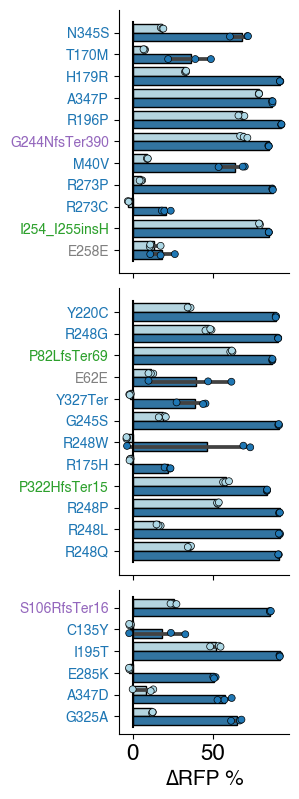

In [29]:
#and plotting
melted2 = melted2.rename(columns ={'delta_rfp': '∆RFP+ %'})

colors = ["lightblue", "tab:blue"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(3,1, figsize=(3,8), height_ratios= [len(high1), len(med1), len(low1)], sharex=True)
hue_order=['1','2']
g = sns.barplot(data = melted2[melted2['efficiency']=='high'],y='HGVSp',x='∆RFP+ %' ,hue='Timepoint',order=high['HGVSp'], linewidth=1, edgecolor='black', hue_order = hue_order, ax=ax[0])
gg = sns.stripplot(data = melted2[melted2['efficiency']=='high'],y='HGVSp',x='∆RFP+ %' ,hue='Timepoint',order=high['HGVSp'], hue_order = hue_order, dodge=True, ax=ax[0],linewidth=.5, edgecolor='black',)

g2 = sns.barplot(data = melted2[melted2['efficiency']=='medium'],y='HGVSp',x='∆RFP+ %' ,hue='Timepoint',order=med['HGVSp'], linewidth=1, edgecolor='black', hue_order = hue_order, ax=ax[1])
gg = sns.stripplot(data = melted2[melted2['efficiency']=='medium'],y='HGVSp',x='∆RFP+ %' ,hue='Timepoint',order=med['HGVSp'], hue_order = hue_order, dodge=True,ax=ax[1],linewidth=.5, edgecolor='black',)

g3 = sns.barplot(data = melted2[melted2['efficiency']=='low'],y='HGVSp',x='∆RFP+ %' ,hue='Timepoint',order=low['HGVSp'], linewidth=1, edgecolor='black', hue_order = hue_order, ax=ax[2])
gg = sns.stripplot(data = melted2[melted2['efficiency']=='low'],y='HGVSp',x='∆RFP+ %' ,hue='Timepoint',order=low['HGVSp'], hue_order = hue_order, dodge=True,ax=ax[2], linewidth=.5, edgecolor='black',)

#-----and making the plot pretty

ax[0].legend_.remove()
ax[1].legend_.remove()
ax[2].legend_.remove()
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('∆RFP %', fontsize=15)
#ax[2].tick_params(axis='both', which='major', labelsize=16)

#ax[0].set_title('High Efficiency')
#ax[1].set_title('Medium Efficiency')
#ax[2].set_title('Low Efficiency')
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[2].spines[['top', 'right']].set_visible(False)

c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'grey'}

for i, tick_label in enumerate(g.axes.get_yticklabels()):
    cc = c_dict[high.iloc[i]['Effect']]
    tick_label.set_color(cc)
    tick_label.set_rotation(0)

for i, tick_label in enumerate(g2.axes.get_yticklabels()):
    cc = c_dict[med.iloc[i]['Effect']]
    tick_label.set_color(cc)
    tick_label.set_rotation(0)

for i, tick_label in enumerate(g3.axes.get_yticklabels()):
    cc = c_dict[low.iloc[i]['Effect']]
    tick_label.set_color(cc)
    tick_label.set_rotation(0)

ax[0].plot([0,0],[-.5, len(high)-.5], color='black')
ax[1].plot([0,0],[-.5, len(med)-.5], color='black')
ax[2].plot([0,0],[-.5, len(low)-.5], color='black')

ax[2].tick_params(axis='x', which='major', labelsize=16)

#ax[2].set_xticklabels(fontsize=16)
fig.tight_layout(pad=.75)


In [30]:
ed = dict(zip(comp['HGVSp'], comp['efficiency']))
a549 = a549.rename(columns = {'pegRNA Identity':'HGVSp'})

a549_2 = a549[a549['HGVSp']!='CONTROL']
a549_2['efficiency'] = [ed[i] for i in a549_2['HGVSp']]

melted2 = a549_2[a549_2['Timepoint']!=0]
melted2 = melted2[melted2['Treatment']=='Untreated']

melted2['Timepoint'] = [str(i) for i in melted2['Timepoint']]

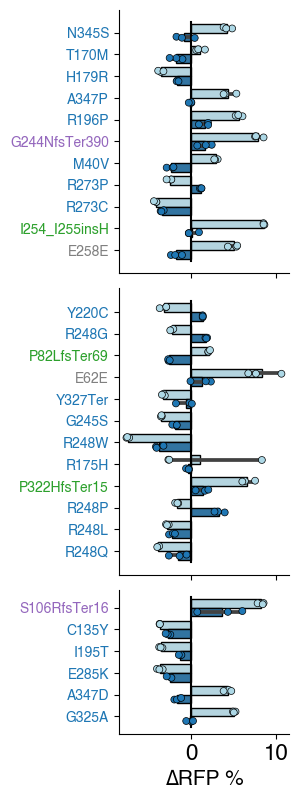

In [31]:
#and plotting
melted2 = melted2.rename(columns ={'delta_rfp': '∆RFP+ %'})

colors = ["lightblue", "tab:blue"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(3,1, figsize=(3,8), height_ratios= [len(high1), len(med1), len(low1)], sharex=True)
hue_order=['1','2']
g = sns.barplot(data = melted2[melted2['efficiency']=='high'],y='HGVSp',x='∆RFP+ %' ,hue='Timepoint',order=high['HGVSp'], linewidth=1, edgecolor='black', hue_order = hue_order, ax=ax[0])
gg = sns.stripplot(data = melted2[melted2['efficiency']=='high'],y='HGVSp',x='∆RFP+ %' ,hue='Timepoint',order=high['HGVSp'], hue_order = hue_order, dodge=True, ax=ax[0],linewidth=.5, edgecolor='black',)

g2 = sns.barplot(data = melted2[melted2['efficiency']=='medium'],y='HGVSp',x='∆RFP+ %' ,hue='Timepoint',order=med['HGVSp'], linewidth=1, edgecolor='black', hue_order = hue_order, ax=ax[1])
gg = sns.stripplot(data = melted2[melted2['efficiency']=='medium'],y='HGVSp',x='∆RFP+ %' ,hue='Timepoint',order=med['HGVSp'], hue_order = hue_order, dodge=True,ax=ax[1],linewidth=.5, edgecolor='black',)

g3 = sns.barplot(data = melted2[melted2['efficiency']=='low'],y='HGVSp',x='∆RFP+ %' ,hue='Timepoint',order=low['HGVSp'], linewidth=1, edgecolor='black', hue_order = hue_order, ax=ax[2])
gg = sns.stripplot(data = melted2[melted2['efficiency']=='low'],y='HGVSp',x='∆RFP+ %' ,hue='Timepoint',order=low['HGVSp'], hue_order = hue_order, dodge=True,ax=ax[2],linewidth=.5, edgecolor='black',)

#-----and making the plot pretty

ax[0].legend_.remove()
ax[1].legend_.remove()
ax[2].legend_.remove()
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('∆RFP %', fontsize=15)
#ax[2].tick_params(axis='both', which='major', labelsize=16)

#ax[0].set_title('High Efficiency')
#ax[1].set_title('Medium Efficiency')
#ax[2].set_title('Low Efficiency')
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[2].spines[['top', 'right']].set_visible(False)

c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'grey'}

for i, tick_label in enumerate(g.axes.get_yticklabels()):
    cc = c_dict[high.iloc[i]['Effect']]
    tick_label.set_color(cc)
    tick_label.set_rotation(0)

for i, tick_label in enumerate(g2.axes.get_yticklabels()):
    cc = c_dict[med.iloc[i]['Effect']]
    tick_label.set_color(cc)
    tick_label.set_rotation(0)

for i, tick_label in enumerate(g3.axes.get_yticklabels()):
    cc = c_dict[low.iloc[i]['Effect']]
    tick_label.set_color(cc)
    tick_label.set_rotation(0)

ax[0].plot([0,0],[-.5, len(high)-.5], color='black')
ax[1].plot([0,0],[-.5, len(med)-.5], color='black')
ax[2].plot([0,0],[-.5, len(low)-.5], color='black')
ax[2].tick_params(axis='x', which='major', labelsize=16)

fig.tight_layout(pad=.75)


## Figure 5e

Scatterplot of the LFC of Nutlin-treated pegRNAs at Day 34 of the screen, and the corresponding ∆RFP % at Day 7 in the competition assay. Points colored by endogenous editing percentage, with “X” indicating no endogenous editing data. rp = Pearson correlation; rs = Spearman correlation.

In [20]:
#load in endogenous sequencing info

endog = pd.read_csv('competition_asay_data_FULL/merged_output.csv')
e = endog[(endog['Cell Line.1']=='A549') & (endog['v1']==False) & (endog['Nutlin']==False)]
e = e[~e['Sample_ID_x'].isin(['D23-11168', 'D23-11174'])]#drop extra sample from v1 of E258E and M40V
#merge competition assay and sensor sequencing data
comp_x = comp.rename(columns = {'pegRNA Identity': 'HGVSp'})
m2 = pd.merge(comp_x, e, on='HGVSp', how='left')

c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'tab:grey'}
m2['colors'] = [c_dict[i] for i in m2['Effect']]

In [21]:
#add info on sensor counts at each timepoint

fp = "crispresso_replicates_merged"

reorder = []

conditions = ['D4', 'D16', 'D16-NUT', 'D25', 'D25-NUT', 'D34', 'D34-NUT']

for i in conditions:
    df = pd.read_csv(f"{fp}/{i}_reps_combined.csv")
    df['peg_id'] = p53_filtered['peg_id']
    reorder.append(df)
    
cp_dict2 = dict(zip(conditions, reorder))

#sample = 'D34'
aa = np.unique(m2['peg_id_x'])

for sample in conditions: 
    b = cp_dict2[sample]

    input_df = p53_filtered.copy()

    b = pd.merge(b, input_df, on='peg_id')

    subset = b[b['peg_id'].isin(aa)]
    assert len(subset)==29, f"missing pegs: {sample}"

    dz = dict(zip(subset['peg_id'], subset['Reads_aligned_all_amplicons']))

    m2[f'sensor_reads_{sample}'] = [dz[i] for i in list(m2['peg_id_x'])]

In [22]:
bb = m2
bb['endog_measured']=True
bb.loc[bb['HGVSp']=='E62E', 'endog_measured']=False
bb.loc[bb['HGVSp']=='E62E', 'corr_perc']=0
sample = 'nutlin'
t = 1
corr_perc_min = 0


bb2 = bb[bb['corr_perc']>=corr_perc_min]
bb2 = bb2[bb2['insufficient_LFC_counts']==False]
#bb2 = bb2[bb2['LFC_nutlin']!=corr_perc_min]
x = list(bb2[f'LFC_{sample}'])
y = list(bb2[f'delta_rfp_{sample}_t{t}'])
hue = bb2['corr_perc']

c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'tab:grey'}
bb2['colors'] = [c_dict[i] for i in bb2['Effect']]


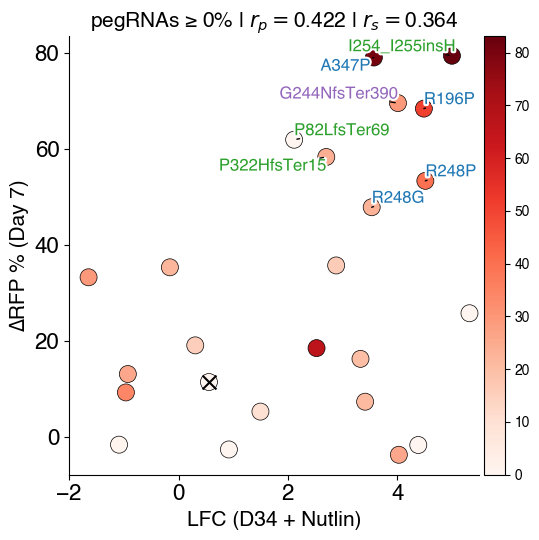

In [23]:
from adjustText import adjust_text
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as PathEffects


fig, ax = plt.subplots(figsize=(5.5,5.5))
g = ax.scatter(x,y, c=hue, cmap='Reds', vmin=0, edgecolor='black', linewidths=.5, s=150)

unmes = bb2[bb2['endog_measured']==False]
x2 = list(unmes['LFC_nutlin'])
y2= list(unmes['delta_rfp_nutlin_t1'])
h = ax.scatter(x2,y2, c = 'black', edgecolor='black', marker = 'x', s=100)


ax.set_xlabel('LFC (D34 + Nutlin)', fontsize=15)
ax.set_ylabel('∆RFP % (Day 7)', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(g, cax=cax, orientation='vertical')
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlim(-2,5.5)
#c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'tab:grey'}

bb3 = bb2[(bb2['delta_rfp_nutlin_t1']>=40)]

x4 = list(bb3[f'LFC_{sample}'])
y4 = list(bb3[f'delta_rfp_{sample}_t{t}'])
t2 = list(bb3['HGVSp'])
c = list(bb3['colors'])
texts = [ax.text(x4[i], y4[i], t2[i], fontsize=12, color=c[i], path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(x4))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

#texts = [ax.text(x[i], y[i], t[i], fontsize=12,) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))

s = np.round(scipy.stats.spearmanr(x,y).statistic, 3)
p = np.round(scipy.stats.pearsonr(x,y).statistic, 3)

#ax.set_title(f'pegRNAs ≥ {corr_perc_min}% endogenous editing\nSpearman R = {s} | Pearson R = {p}', fontsize=15)
ax.set_title(f'pegRNAs ≥ {corr_perc_min}% | '+ '$r_{p}=$' +f'{p} | ' + '$r_{s}=$' + f'{s}', fontsize=15)

fig.tight_layout()

In [24]:
bb = m2
bb['endog_measured']=True
bb.loc[bb['HGVSp']=='E62E', 'endog_measured']=False
bb.loc[bb['HGVSp']=='E62E', 'corr_perc']=0
sample = 'nutlin'
t = 1
corr_perc_min = 10


bb2 = bb[bb['corr_perc']>=corr_perc_min]
bb2 = bb2[bb2['insufficient_LFC_counts']==False]
#bb2 = bb2[bb2['LFC_nutlin']!=corr_perc_min]
x = list(bb2[f'LFC_{sample}'])
y = list(bb2[f'delta_rfp_{sample}_t{t}'])
hue = bb2['corr_perc']

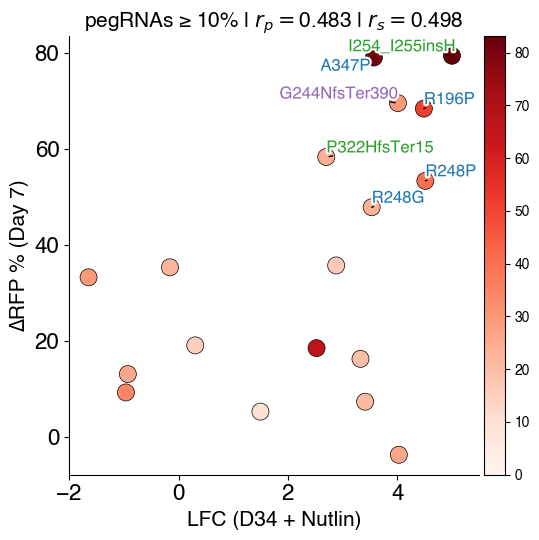

In [25]:
fig, ax = plt.subplots(figsize=(5.5,5.5))
g = ax.scatter(x,y, c=hue, cmap='Reds', vmin=0, edgecolor='black', linewidths=.5, s=150)

unmes = bb2[bb2['endog_measured']==False]
x2 = list(unmes['LFC_nutlin'])
y2= list(unmes['delta_rfp_nutlin_t1'])
h = ax.scatter(x2,y2, c = 'black', edgecolor='black', marker = 'x', s=100)


ax.set_xlabel('LFC (D34 + Nutlin)', fontsize=15)
ax.set_ylabel('∆RFP % (Day 7)', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(g, cax=cax, orientation='vertical')
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlim(-2,5.5)
#c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'tab:grey'}

bb3 = bb2[(bb2['delta_rfp_nutlin_t1']>=40)]

x4 = list(bb3[f'LFC_{sample}'])
y4 = list(bb3[f'delta_rfp_{sample}_t{t}'])
t2 = list(bb3['HGVSp'])
c = list(bb3['colors'])
texts = [ax.text(x4[i], y4[i], t2[i], fontsize=12, color=c[i], path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(x4))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

#texts = [ax.text(x[i], y[i], t[i], fontsize=12,) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))

s = np.round(scipy.stats.spearmanr(x,y).statistic, 3)
p = np.round(scipy.stats.pearsonr(x,y).statistic, 3)

#ax.set_title(f'pegRNAs ≥ {corr_perc_min}% endogenous editing\nSpearman R = {s} | Pearson R = {p}', fontsize=15)
ax.set_title(f'pegRNAs ≥ {corr_perc_min}% | '+ '$r_{p}=$' +f'{p} | ' + '$r_{s}=$' + f'{s}', fontsize=15)

fig.tight_layout()

## Figure 5f

Same as (e) but for the untreated condition. 

In [26]:
bb = m2
bb['endog_measured']=True
bb.loc[bb['HGVSp']=='E62E', 'endog_measured']=False
bb.loc[bb['HGVSp']=='E62E', 'corr_perc']=0
sample = 'untreated'
t = 1
corr_perc_min = 0


bb2 = bb[bb['corr_perc']>=corr_perc_min]
bb2 = bb2[bb2['insufficient_LFC_counts']==False]
#bb2 = bb2[bb2['LFC_nutlin']!=corr_perc_min]
x = list(bb2[f'LFC_{sample}'])
y = list(bb2[f'delta_rfp_{sample}_t{t}'])
hue = bb2['corr_perc']

c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'tab:grey'}
bb2['colors'] = [c_dict[i] for i in bb2['Effect']]

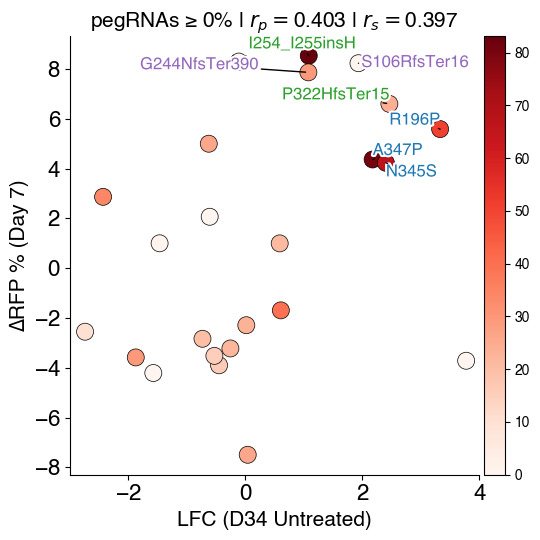

In [27]:
fig, ax = plt.subplots(figsize=(5.5,5.5))
g = ax.scatter(x,y, c=hue, cmap='Reds', vmin=0, edgecolor='black', linewidths=.5, s=150)

unmes = bb2[bb2['endog_measured']==False]
x2 = list(unmes[f'LFC_{sample}'])
y2= list(unmes[f'delta_rfp_{sample}_t{t}'])
h = ax.scatter(x2,y2, c = 'black', edgecolor='black', marker = 'x', s=100)


ax.set_xlabel('LFC (D34 Untreated)', fontsize=15)
ax.set_ylabel('∆RFP % (Day 7)', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(g, cax=cax, orientation='vertical')
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlim(-3, 4)

#c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'tab:grey'}

bb3 = bb2[(bb2[f'delta_rfp_{sample}_t{t}']>=3.5) & (bb2['LFC_untreated']>=.5)]
x4 = list(bb3[f'LFC_{sample}'])
y4 = list(bb3[f'delta_rfp_{sample}_t{t}'])
t2 = list(bb3['HGVSp'])
c = list(bb3['colors'])
texts = [ax.text(x4[i], y4[i], t2[i], fontsize=12, color=c[i], path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(x4))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

#texts = [ax.text(x[i], y[i], t[i], fontsize=12,) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))

s = np.round(scipy.stats.spearmanr(x,y).statistic, 3)
p = np.round(scipy.stats.pearsonr(x,y).statistic, 3)

#ax.set_title(f'pegRNAs ≥ {corr_perc_min}% endogenous editing\nSpearman R = {s} | Pearson R = {p}', fontsize=15)
ax.set_title(f'pegRNAs ≥ {corr_perc_min}% | '+ '$r_{p}=$' +f'{p} | ' + '$r_{s}=$' + f'{s}', fontsize=15)

fig.tight_layout()

In [28]:
bb = m2
bb['endog_measured']=True
bb.loc[bb['HGVSp']=='E62E', 'endog_measured']=False
bb.loc[bb['HGVSp']=='E62E', 'corr_perc']=0
sample = 'untreated'
t = 1
corr_perc_min = 10


bb2 = bb[bb['corr_perc']>=corr_perc_min]
bb2 = bb2[bb2['insufficient_LFC_counts']==False]
#bb2 = bb2[bb2['LFC_nutlin']!=corr_perc_min]
x = list(bb2[f'LFC_{sample}'])
y = list(bb2[f'delta_rfp_{sample}_t{t}'])
hue = bb2['corr_perc']

c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'tab:grey'}
bb2['colors'] = [c_dict[i] for i in bb2['Effect']]

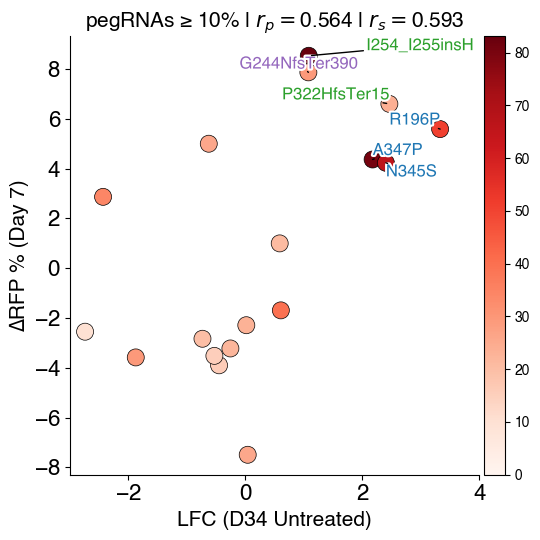

In [29]:
fig, ax = plt.subplots(figsize=(5.5,5.5))
g = ax.scatter(x,y, c=hue, cmap='Reds', vmin=0, edgecolor='black', linewidths=.5, s=150)

unmes = bb2[bb2['endog_measured']==False]
x2 = list(unmes[f'LFC_{sample}'])
y2= list(unmes[f'delta_rfp_{sample}_t{t}'])
h = ax.scatter(x2,y2, c = 'black', edgecolor='black', marker = 'x', s=100)


ax.set_xlabel('LFC (D34 Untreated)', fontsize=15)
ax.set_ylabel('∆RFP % (Day 7)', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(g, cax=cax, orientation='vertical')
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlim(-3, 4)

#c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'tab:grey'}

bb3 = bb2[(bb2[f'delta_rfp_{sample}_t{t}']>=3.5) & (bb2['LFC_untreated']>=.5)]
x4 = list(bb3[f'LFC_{sample}'])
y4 = list(bb3[f'delta_rfp_{sample}_t{t}'])
t2 = list(bb3['HGVSp'])
c = list(bb3['colors'])
texts = [ax.text(x4[i], y4[i], t2[i], fontsize=12, color=c[i], path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(x4))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

#texts = [ax.text(x[i], y[i], t[i], fontsize=12,) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))

s = np.round(scipy.stats.spearmanr(x,y).statistic, 3)
p = np.round(scipy.stats.pearsonr(x,y).statistic, 3)

#ax.set_title(f'pegRNAs ≥ {corr_perc_min}% endogenous editing\nSpearman R = {s} | Pearson R = {p}', fontsize=15)
ax.set_title(f'pegRNAs ≥ {corr_perc_min}% | '+ '$r_{p}=$' +f'{p} | ' + '$r_{s}=$' + f'{s}', fontsize=15)

fig.tight_layout()

## Figure 5g

Scatterplot of sensor editing percentage at Day 16 and the corresponding endogenous editing percentage of pure A549-PEmax-pegRNA cell lines for pegRNAs included in competition assays.

48

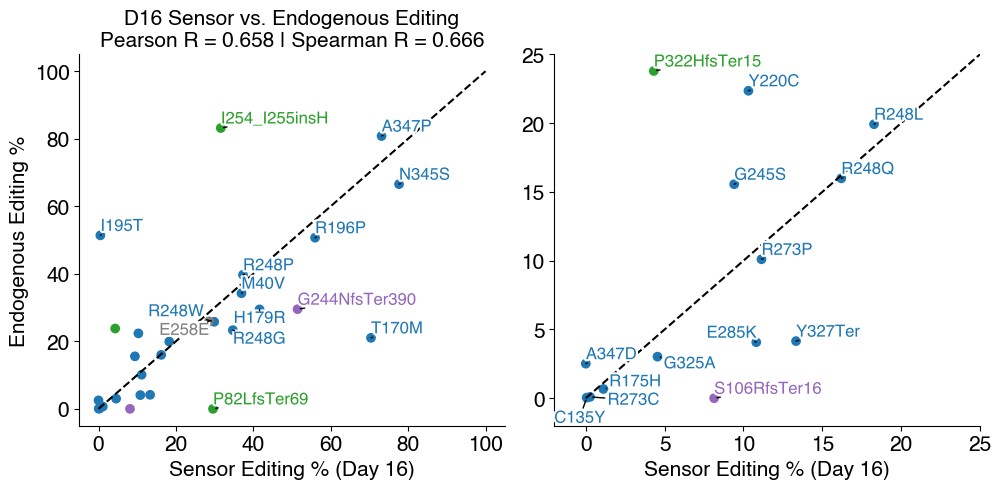

In [30]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
val = 'D16'
m1 = m2[m2['HGVSp']!='E62E']
a = list(m1['corr_perc'])
b = list(m1[f'corr_perc_{val}'])

rho = np.round(scipy.stats.spearmanr(a,b).statistic, 3)
R = np.round(scipy.stats.pearsonr(a,b).statistic, 3)

ax[0].scatter(b,a, color=m1['colors'])
ax[0].plot([0,100],[0,100], linestyle='dashed', color='black')
ax[0].spines[['top', 'right']].set_visible(False)      
ax[1].scatter(b,a, color=m1['colors'])
ax[1].plot([0,100],[0,100], linestyle='dashed', color='black')
ax[1].spines[['top', 'right']].set_visible(False)   

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].set_xlabel('Sensor Editing % (Day 16)', fontsize=15)
ax[1].set_xlabel('Sensor Editing % (Day 16)', fontsize=15)

ax[0].set_ylabel('Endogenous Editing %', fontsize=15)
ax[0].set_title(f'{val} Sensor vs. Endogenous Editing\nPearson R = {R} | Spearman R = {rho}', fontsize=15)

ax[1].set_xlim(-2,25)
ax[1].set_ylim(-2,25)
fig.tight_layout()


above25 = m1[~((m1[f'corr_perc_{val}']<25) & (m1['corr_perc']<25))]

a2 = list(above25['corr_perc'])
b2 = list(above25[f'corr_perc_{val}'])
t = list(above25['HGVSp'])
c = list(above25['colors'])
texts = [ax[0].text(b2[i], a2[i], t[i], fontsize=12, color=c[i], path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(a2))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

#texts = [ax.text(x[i], y[i], t[i], fontsize=12,) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'}, ax=ax[0], arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))

below25 = m1[((m1[f'corr_perc_{val}']<25) & (m1['corr_perc']<25))]

a2 = list(below25['corr_perc'])
b2 = list(below25[f'corr_perc_{val}'])
t = list(below25['HGVSp'])
c = list(below25['colors'])
texts = [ax[1].text(b2[i], a2[i], t[i], fontsize=12, color=c[i], path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(a2))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

#texts = [ax.text(x[i], y[i], t[i], fontsize=12,) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'}, ax=ax[1], arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))

